# Data exploration for Liver Challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image
import tensorflow as tf
import collections
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 1. Import data
N.B: In the frame of the challenge, JFR data can only be used during the challenge by competitors. Once the challenge is finished, data under study must be deleted

In [2]:
folder_data_path = "C:/Users/vince/Documents/DataChallengeJFR/foie_train/"

In [12]:
df = pd.read_csv(folder_data_path + "foie_train_set.csv")
df = df.set_index("id")
n_data = df.shape[0]
print("Number of echos: {}".format(n_data))
print(df["Type de lesion"].value_counts())
print(df.head())

Number of echos: 189
Foie Homogene    133
Metastase         27
Kyste             11
Angiome            9
HNF                6
CHC                3
Name: Type de lesion, dtype: int64
         Benin  Lesion  Malin Type de lesion
id                                          
foie_1       0       0      0  Foie Homogene
foie_5       0       0      0  Foie Homogene
foie_9       0       0      0  Foie Homogene
foie_11      0       0      0  Foie Homogene
foie_12      0       0      0  Foie Homogene


It appears that the dataset is highly unbalanced among the 6 classes. Same classes have too few samples for the model to learn properly. One should consider using resampling methods in order to tackle the entire multi-classification problem.

We will begin with the binary-classification problem: given an ultrasound, can we predict that the liver has a lesion?
Thus only 2 classes are studied below: with and without lesion. These are the 2 biggest classes in terms of samples which is why we start by them.

## 2. Data pre-procesing

Open images, resize them at the minimal commun size then convert them into 2D numpy arrays. As inputs of the machine learning models we will use 2D numpy arrays for data and one-hot vectors for labels.

Finally we split our dataset into train and test data (necessary to evaluate the accuracy of the models)

In [4]:
for f in df.index :
    im = Image.open(folder_data_path + "foie_train_set/" + f + ".bmp")
    im = im.resize((960,720), PIL.Image.BICUBIC)
    array_one = np.array(im)
    array_one = np.expand_dims(array_one, axis=0)
    if f == "foie_1":
        array_all = array_one
    else :
        array_all = np.append(array_all, array_one, axis=0)

In [5]:
X_all_orig = array_all
X_all_orig = X_all_orig.astype('float32')
y_all_orig = df["Lesion"].values
y_all_orig = y_all_orig.astype('float32')
print("All data shape: {}".format(X_all_orig.shape))
print("All label shape: {}".format(y_all_orig.shape))

All data shape: (189, 720, 960, 3)
All label shape: (189,)


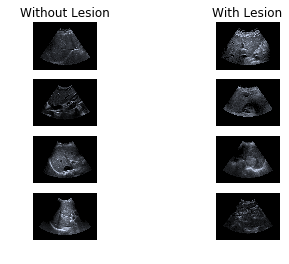

In [6]:
# Visualize a few examples of orig images from each class
classes = ["Without Lesion", "With Lesion"]
num_classes = len(classes)
samples_per_class = 4
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_all_orig == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        xx = X_all_orig[idx,:,:,:]
        xx -= np.min(xx)
        xx /= np.max(xx)
        plt.imshow(xx)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
# Generate train and test set from orig
n = X_all_orig.shape[0]
test_size = n//6
print('Split: {} testing and {} training samples'.format(test_size, n - test_size))
perm = np.random.permutation(n)
X_test_orig  = X_all_orig[perm[:test_size]]
X_train_orig = X_all_orig[perm[test_size:]]
y_test_orig  = y_all_orig[perm[:test_size]]
y_train_orig = y_all_orig[perm[test_size:]]

Split: 31 testing and 158 training samples


In [8]:
# Data pre-processing
n = X_train_orig.shape[0]
train_data = np.zeros([n,720*960])
for i in range(n):
    xx = X_train_orig[i,:,:,:]
    xx = np.linalg.norm(xx,axis=2)
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    train_data[i] = np.reshape(xx,[-1])

n = X_test_orig.shape[0]
test_data = np.zeros([n,720*960])
for i in range(n):
    xx = X_test_orig[i,:,:,:]
    xx = np.linalg.norm(xx,axis=2)
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    test_data[i] = np.reshape(xx,[-1])

print("Train data shape: {}".format(train_data.shape))
print("Test data shape: {}".format(test_data.shape))

Train data shape: (158, 691200)
Test data shape: (31, 691200)


In [9]:
# Convert label values to one_hot vector
from scipy.sparse import coo_matrix
def convert_to_one_hot(a,max_val=None):
    N = a.size
    data = np.ones(N,dtype=int)
    sparse_out = coo_matrix((data,(np.arange(N),a.ravel())), shape=(N,max_val))
    return np.array(sparse_out.todense())

train_labels = convert_to_one_hot(y_train_orig,2)
test_labels = convert_to_one_hot(y_test_orig,2)
print("Train label shape: {}".format(train_labels.shape))
print("Test label shape: {}".format(test_labels.shape))

Train label shape: (158, 2)
Test label shape: (31, 2)


# Model1: CNN

Dealing with an image processing classication problem, a convolutional neural network (CNN) classifier can bring very promising results. Given the few number of data provided, one should use anti over-fitting techniques such as : cross-validation and dropout technique.

The mathemical formula of the 2-layer CNN implemented is exposed below:

$$
y=\textrm{softmax}(ReLU(x\ast W_1+b_1)W_2+b_2)
$$


In [10]:
# Define computational graph (CG)
batch_size = 31         # batch size
d = train_data.shape[1]  # data dimensionality
nc = 2                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())
d = tf.placeholder(tf.float32);

# Convolutional layer
K = 5   # size of the patch
F = 10  # number of filters
ncl = K*K*F
Wcl = tf.Variable(tf.truncated_normal([K,K,1,F], stddev=tf.sqrt(2./tf.to_float(ncl)) )); #print('Wcl=',Wcl.get_shape())
bcl = tf.Variable(tf.zeros([F])); #print('bcl=',bcl.get_shape())
x_2d = tf.reshape(xin, [-1,32,32,1]); #print('x_2d=',x_2d.get_shape())
x = tf.nn.conv2d(x_2d, Wcl, strides=[1, 1, 1, 1], padding='SAME')
x += bcl; #print('x2=',x.get_shape())

# ReLU activation
x = tf.nn.relu(x)

# Dropout
x = tf.nn.dropout(x, d)

# Fully Connected layer
nfc = 720*960*F
x = tf.reshape(x, [batch_size,-1]); #print('x3=',x.get_shape())
Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(6./tf.to_float(nfc+nc)) )); #print('Wfc=',Wfc.get_shape())
bfc = tf.Variable(tf.zeros([nc])); #print('bfc=',bfc.get_shape())
y = tf.matmul(x, Wfc); #print('y1=',y,y.get_shape())
y += bfc; #print('y2=',y,y.get_shape())

# Softmax
y = tf.nn.softmax(y); #print('y3=',y,y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.025).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(501):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for variable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y, d: 0.25})
    
    # Run CG for test set
    if not i%20:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels, d: 1.0})
        print('test accuracy=',acc_test)

Instructions for updating:
Use `tf.global_variables_initializer` instead.

Iteration i= 0 , train accuracy= 0.32258064 , loss= 0.6936452
test accuracy= 0.83870965

Iteration i= 20 , train accuracy= 0.8064516 , loss= 0.6069698
test accuracy= 0.83870965

Iteration i= 40 , train accuracy= 0.6451613 , loss= 0.6191419
test accuracy= 0.83870965

Iteration i= 60 , train accuracy= 0.7419355 , loss= 0.4938952
test accuracy= 0.83870965

Iteration i= 80 , train accuracy= 0.8064516 , loss= 0.41914937
test accuracy= 0.83870965

Iteration i= 100 , train accuracy= 0.87096775 , loss= 0.33677414
test accuracy= 0.8064516

Iteration i= 120 , train accuracy= 0.9032258 , loss= 0.36793745
test accuracy= 0.8064516

Iteration i= 140 , train accuracy= 0.87096775 , loss= 0.30840594
test accuracy= 0.8064516

Iteration i= 160 , train accuracy= 0.9032258 , loss= 0.28002858
test accuracy= 0.83870965

Iteration i= 180 , train accuracy= 1.0 , loss= 0.1922704
test accuracy= 0.83870965

Iteration i= 200 , train accurac

It seems here that the CNN model learns quickly but seems to overfit since the testing performances are not improving much and for some iterations even are worsening. The drop-out method here is not enough to avoid overfitting.